#  Randomized Singular Value Decomposition (rSVD)
************************************************************************************
Let $\mathbf{A}$ be a matrix of dimension $m\times n$. The approximate low-rank $k$ singular value decomposition admits the following factorization 

\begin{equation}
	\begin{array}{cccccccccc}			
	\mathbf{A}  & \approx & \mathbf{U} & \mathbf{\Sigma}  & \mathbf{V}^\top\\
	m\times n &   &  m\times k & k\times k  & k\times n
	\end{array} 
\end{equation}

$\mathbf{U}$ denotes the left singular vectors, $\mathbf{V}$ are the right singular, and $\mathbf{\Sigma}$ contains the non-negative singular values vectors.

To demonstrate the randomized SVD we use image compression as an example in the following. Specifically, the singular value decomposition can be used to obtain a low-rank approximation to high-dimensional data. Image compression is a simple and illustrative example of this. Interestingly, most natural images can be faithfully recovered from a relatively small set of basis functions. 

### Get Started

First, we load some standard libraries:

In [1]:
import numpy as np
import scipy as sci
from scipy import ndimage 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white")

### The Dataset

Next, we load a  $1600 \times 2560$ grayscale image:

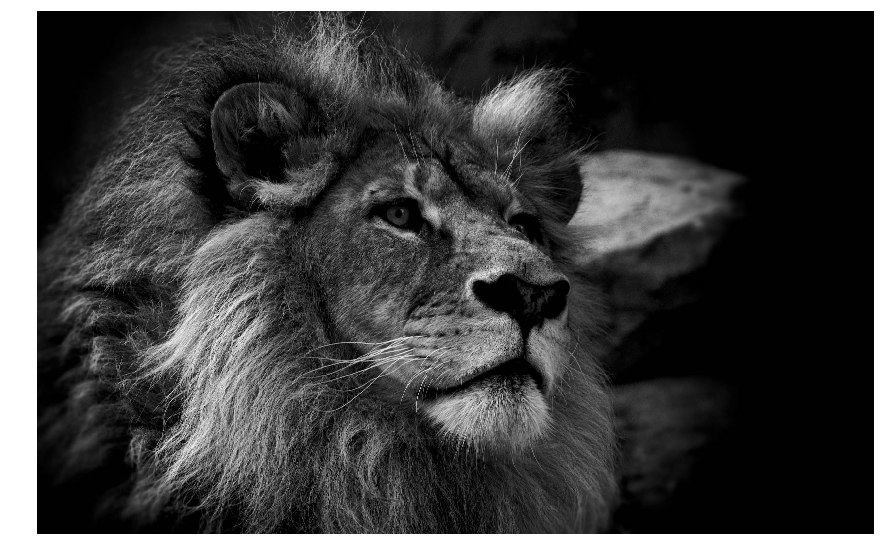

('Dimensions:', (1600, 2560))


In [2]:
# Read in image
A = sci.ndimage.imread('../data/lion.jpg', flatten=True)

# Display image
fig = plt.figure(figsize=(15, 11))
plt.imshow(A, cmap = 'gray')
plt.axis('off')
plt.show()

# Print shape
m,n = A.shape
print('Dimensions:', A.shape)

To start with, we need to define the target rank $k=150$, i.e, we need to decide how many dominant singular vectors and values we aim to approximate. Here, we use the arbitrary target rank $k=150$, but you can change this value. 

In [3]:
k=100 

In practice we should introduce some slight oversampling in addition, here we use $p=10$.

In [4]:
p=10

The probabilistic framework to compute the near-optimal SVD can be devided into the following two logical steps:

* $\textbf{Stage A:}$ Construct a low dimensional subspace that approximates the range of $\mathbf{A} \in \mathbb{R}^{m\times n}$. Specifically, it is the aim to find a matrix $\mathbf{Q} \in \mathbb{R}^{m\times k}$ with orthonormal columns, where $k$ denotes the target rank, such that $\mathbf{A} \approx \mathbf{Q}\mathbf{Q}^\intercal\mathbf{A}$ is satisfied. 

* $\textbf{Stage B:}$ Form a smaller matrix $\mathbf{B} \in \mathbb{R}^{k\times n}$ by restricting the high-dimensional input matrix to the low-dimensional space spanned by the near-optimal basis $\mathbf{Q}$. This smaller matrix can then be used to compute a desired low-rank approximation.

### Stage A
***********

Okay, now the first step is to generate a random test matrix $\mathbf{\Omega}$ of dimension $n times l$ were $l=k+p$. We start with drawing the entries of $\mathbf{\Omega}$ from the standard normal distribution, but you can use the uniform distribution or independent Rademacher entries as well. 

In [5]:
Omega = sci.random.standard_normal((n, (k+p))) # standard normal distribution
#Omega = sci.random.uniform(n, (k+p)) # standard normal distribution
#Omega = sci.random.choice(([-1,1]), (n, (k+p)) ) # Rademacher entries

Next, we compute the samples matrix $\mathbf{Y}$, i.e., we sketch the column space of the input matrix (image) $\mathbf{A}$.

In [6]:
Y = A.dot(Omega)

To improve the accuracy of the basis, we can perform additional power iterations. I leave this as an exercise.

In [7]:
q = 2 # number of (optional) power iterations

#for i in xrange(q):
    #perform power iterations
    #
    #
    #
    

Y forms a basis for the column space of the input matrix, we can use the 'economic' QR decomposition to form a natural (orthonormal) basis, so that $\mathbf{Q}^\top\mathbf{Q}=\mathbf{I}$. 

In [8]:
Q , _ = sci.linalg.qr( Y ,  mode='economic' ) 

### Stage B
************
Now, given the near-optimal basis $\mathbf{Q}$, we aim to find a smaller matrix $\mathbf{B} \in \mathbb{R}^{k\times n}$. Therefor, we simply project the high-dimensional input matrix $\mathbf{A}$ to the low-dimensional space as 
\begin{equation}
\mathbf{B} = \mathbf{Q}^\top\mathbf{A}.
\end{equation}


In [9]:
B = Q.T.dot(A)

The approximate SVD is computed using a standard (deterministic) algorithm so that we attain the following decomposition
\begin{equation} 
\mathbf{B} = \mathbf{\tilde{U}} \mathbf{\Sigma}\mathbf{V}^\top.	
\end{equation} 


In [10]:
Utilde, s , Vt = sci.linalg.svd( B , full_matrices=False)

Utilde = Utilde[:,0:k] # extract the k dominant left singular vectors
s = s[0:k] # extract the k dominant singular values
Vt = Vt[0:k,:] # extract the k dominant right singular vectors

It remains to recover the high-dimensional left singular vectors. Recall that
	$\mathbf{A} \approx  \mathbf{Q}{\mathbf{Q^{\top}}\mathbf{A}} = \mathbf{Q} {\mathbf{B}} = \mathbf{Q}\mathbf{\tilde{U}} \mathbf{\Sigma}\mathbf{V^{\top}}= \mathbf{U} \mathbf{\Sigma}\mathbf{V^{\top}}$. Hence, $\mathbf{\tilde{U}}:= \mathbf{Q}\mathbf{\tilde{U}}$.	

In [11]:
U = Q.dot(Utilde)

Let's see how good the approximation is.

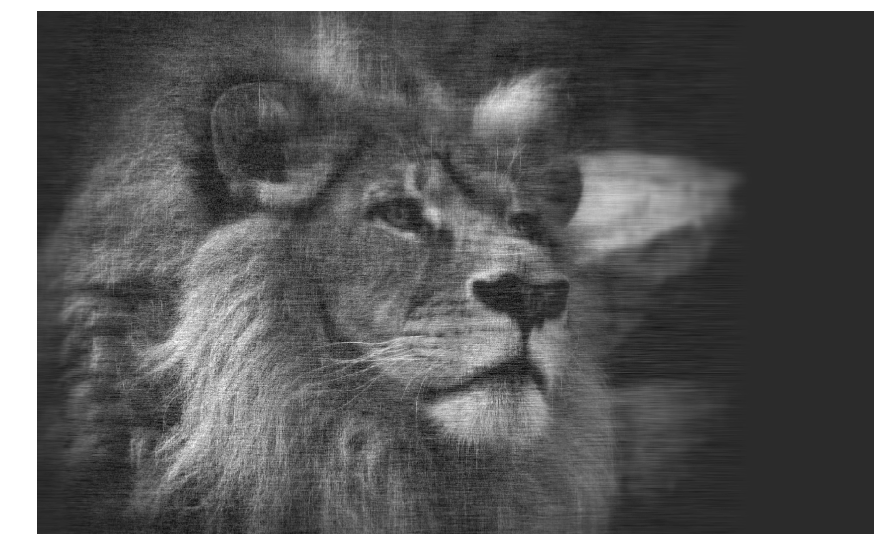

In [12]:
#A_rsvd = U.dot(np.diag(s)).dot(Vt)
A_rsvd = (U*s).dot(Vt)

# Display image
fig = plt.figure(figsize=(15, 11))
plt.imshow(A_rsvd, cmap = 'gray')
plt.axis('off')
plt.show()

We can compute the relative reconstruction error to quantify the performance of the randomized algorithm.

In [13]:
#Print relative error
print('Relative error:', sci.linalg.norm(A-A_rsvd)/sci.linalg.norm(A))

('Relative error:', 0.2276932394965368)


How does the error compares to the deterministic SVD?

In [14]:
U, s , Vt = sci.linalg.svd( A , full_matrices=False)

U = U[:,0:k] # extract the k dominant left singular vectors
s = s[0:k] # extract the k dominant singular values
Vt = Vt[0:k,:] # extract the k dominant right singular vectors

In [15]:
A_svd = (U*s).dot(Vt)

In [16]:
#Print relative error
print('Relative error:', sci.linalg.norm(A-A_svd)/sci.linalg.norm(A))

('Relative error:', 0.17218083)


We see that the deterministic algorithm is more accurate, however, computing the randomized SVD using about 2 power (subspace) iterations yields the near-optimal approximation.

Let's load the rsvd function from the ristretto package and compute the low-rank approximation with $q=2$.

In [17]:
from ristretto.mf import rsvd

In [18]:
U, s , Vt = rsvd( A , k=k, p=10, q=2)

In [19]:
A_rsvd = (U*s).dot(Vt)
#Print relative error
print('Relative error:', sci.linalg.norm(A-A_rsvd)/sci.linalg.norm(A))

('Relative error:', 0.17474526)


The difference in terms of the relative error is marginal now. 

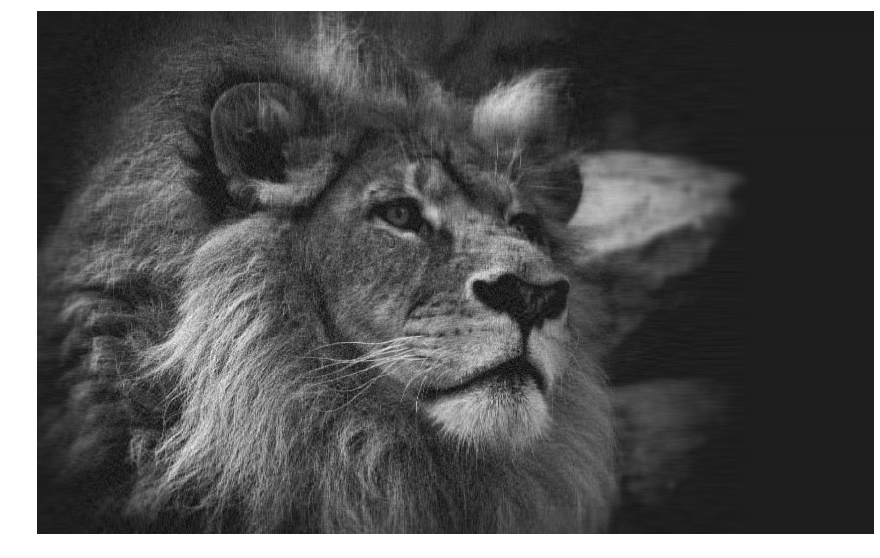

In [21]:
#A_rsvd = U.dot(np.diag(s)).dot(Vt)
A_rsvd = (U*s).dot(Vt)

# Display image
fig = plt.figure(figsize=(15, 11))
plt.imshow(A_rsvd, cmap = 'gray')
plt.axis('off')
plt.show()

Finally, let us compare the computational costs of the deterministic and randomized algorithm. 

In [22]:
%%timeit
U, s , Vt = sci.linalg.svd( A , full_matrices=False)

1 loop, best of 3: 2.45 s per loop


In [23]:
%%timeit
U, s , Vt = rsvd( A , k=k, p=10, q=2)

10 loops, best of 3: 145 ms per loop


How much words of storage does the low-rank SVD require? 

In [24]:
words_svd = U.size + Vt.size
print('Words of memory:', words_svd)

('Words of memory:', 416000)


The original (uncompressed) image requires 

In [25]:
words_A = A.size
print('Words of storage:', words_A)

('Words of storage:', 4096000)


Thus, we require only about

In [26]:
np.float32(words_svd) / words_A

0.1015625

of the total storage.

## A blocked image compression scheme
*****************************************************

How about we divide the image into smaller blocks? Then, instead of computing global features, we compute local features to compress each block individually.

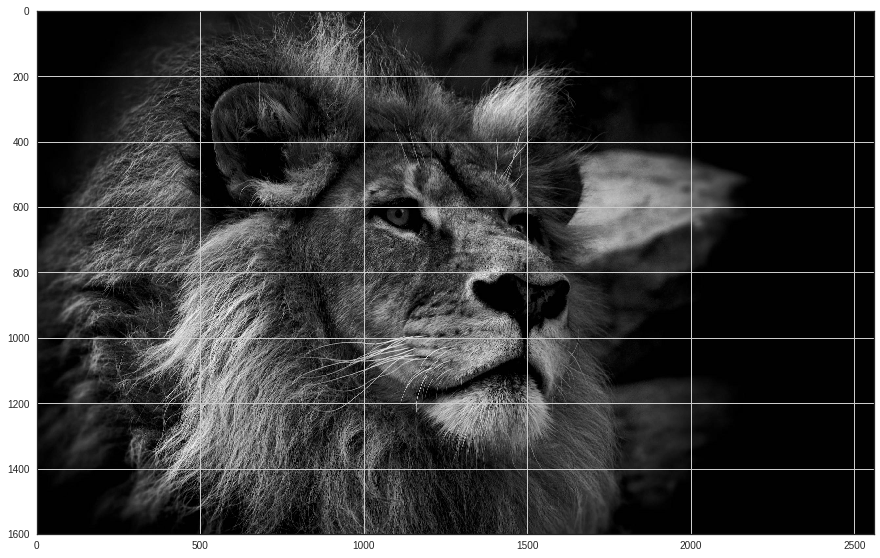

('Dimensions:', (1600, 2560))


In [27]:
# Display image
fig = plt.figure(figsize=(15, 11))
plt.imshow(A, cmap = 'gray')
plt.grid('on')
plt.show()

# Print shape
m,n = A.shape
print('Dimensions:', A.shape)


Let's say we want to block the input image into $80\times 80$ subblocks, each of dimension $20\times 32$.

In [28]:
n_blocks = 40 # number of blocks
i_step = 1600 / n_blocks
print(1600. / n_blocks)
j_step = 2560 / n_blocks
print(2560. / n_blocks)

40.0
64.0


Next we define the target-rank:

In [30]:
k = 3

Note that we use a much smaller target-rank then above. You should test different target-ranks to evaluate the difference of the approximation quality.

In the following we compute a low-rank approximation for each block using the randomized SVD. Note that the code in the following is not efficient, therefor the code should be readable. 

In [31]:
A_re = np.zeros(A.shape) # create a matrix 
words = 0 # set word count to 0
i, j, iend, jend = 0, 0, 0, 0 # init indices

for row in xrange(n_blocks): # loop over the the rows
    iend += i_step

    for col in range(n_blocks): # loop over the the columns
        
        jend += j_step
        block = A[i:iend, j:jend] # tacke a subset (block) of the input matrix
        U, s , Vt = rsvd( block , k=k, p=10, q=2) # compute rsvd
        A_re[i:iend, j:jend] = (U*s).dot(Vt) # low-rank appproximation
        j += j_step
        words += U.size + Vt.size # count words of storage
        
    i += i_step # go to next row of blocks
    j, jend = 0, 0 #set column index to 0

The resulting relative approximation error is

In [32]:
print('Relative error:', sci.linalg.norm(A-A_re)/sci.linalg.norm(A))

('Relative error:', 0.17692221470260766)


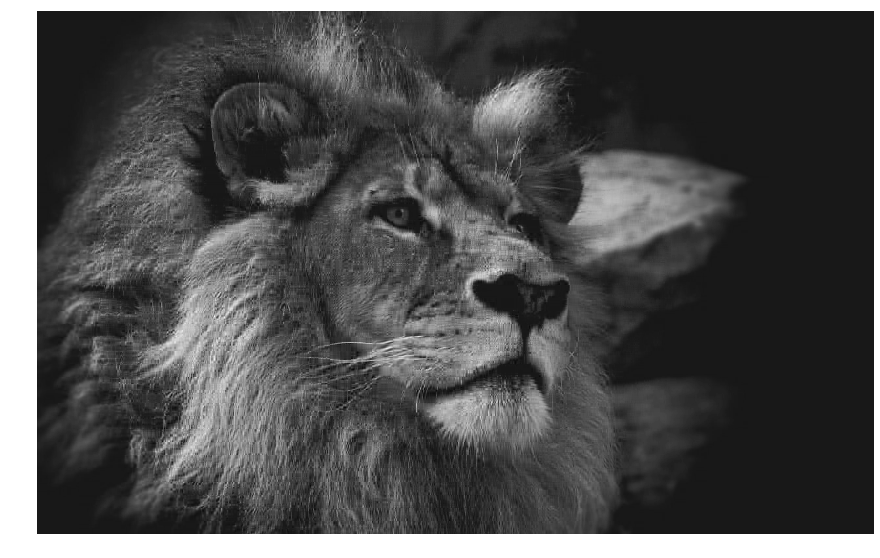

In [33]:
# Display image
fig = plt.figure(figsize=(15, 11))
plt.imshow(A_re, cmap = 'gray')
plt.axis('off')
plt.show()

We just used about

In [34]:
print('Words:', words)

('Words:', 499200)


Specifically, the blocked scheme requires about 

In [35]:
np.float32(words) / words_A

0.121875

of storage.